In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

In [74]:
#base deep seas
#file_path2 = "C:\Users\7king\Desktop\Projet Python\projet_python_alcool\Deepseas\dp.xlsx"

df = pd.read_csv(r"C:\Users\7king\Desktop\Projet Python\projet_python_alcool\Deepseas\deep.csv", sep=';', encoding='utf-8', low_memory=False, na_values=" ", decimal=',')
#df.describe() 


In [75]:
variables = ["COUNTRY","SD_1", "SD_2", "SD_4","SD_6", "SD_7", 
             "SD_8","SD_9", "SD_10", "sd_20month", "Demo_Empl" ,"social_class",
             "bsqf_alc", "f_1b", "RSOD_5a", "RSOD_5b", "RSOD_5c", "cbsqf_beer", "cbsqf_spir", "cbsqf_wine",
             "RSOD_5d", "RSOD_2b", "RSOD_7b", "CH_1", "WB_1", "WB_2", "WB_3"]
data = df[variables]
#expliquer sélection: la plupart des variables étaient redondantes...


In [76]:
country_mapping = {
    10: 'Austria',
    11: 'Belgium',
    12: 'BosniaHerzegovina',
    13: 'Bulgaria',
    14: 'Catalunya',
    15: 'Croatia',
    16: 'Cyprus',
    17: 'Czech Republic',
    18: 'Denmark',
    19: 'Estonia',
    20: 'Finland',
    21: 'France',
    22: 'Germany',
    23: 'Greece',
    24: 'Hungary',
    25: 'Iceland',
    26: 'Ireland',
    27: 'Italy',
    28: 'Latvia',
    29: 'Lithuania',
    30: 'Luxembourg',
    31: 'Malta',
    32: 'Moldova',
    33: 'Netherlands',
    34: 'Norway',
    35: 'Poland',
    36: 'Portugal',
    37: 'Romania',
    38: 'Serbia',
    39: 'Slovakia',
    40: 'Slovenia',
    41: 'Spain',
    42: 'Sweden',
    43: 'United Kingdom',
}
data['COUNTRY'] = data['COUNTRY'].map(country_mapping)

C:\Users\7king\AppData\Local\Temp\ipykernel_12600\3856511148.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['COUNTRY'] = data['COUNTRY'].map(country_mapping)


<Axes: >

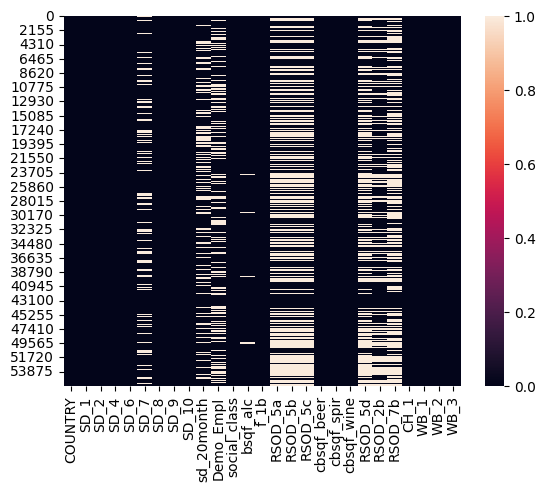

In [77]:
sns.heatmap(data.isna())

In [ ]:
# 1. Définir les taux de conversion (Unité Locale -> EUR) au 01/01/2020.
# Le taux est la valeur de 1 unité de la devise locale en EUR (1 / Taux (1 EUR = X Unités))
# Par exemple, pour PLN : 1 EUR = 4.256 PLN, donc 1 PLN = 1/4.256 EUR = 0.235 EUR
# Pour le GBP : 1 EUR = 0.844 GBP, donc 1 GBP = 1/0.844 EUR = 1.185 EUR

conversion_rates = {
    # Pays en EUR (Taux = 1)
    'Austria': 1.0, 'Belgium': 1.0, 'Cyprus': 1.0, 'Finland': 1.0, 'France': 1.0,
    'Germany': 1.0, 'Greece': 1.0, 'Ireland': 1.0, 'Italy': 1.0, 'Luxembourg': 1.0,
    'Malta': 1.0, 'Netherlands': 1.0, 'Portugal': 1.0, 'Slovakia': 1.0, 'Slovenia': 1.0,
    'Spain': 1.0, 'Catalunya': 1.0, 'Estonia': 1.0, 'Latvia': 1.0, 'Lithuania': 1.0,

    # Hors Zone Euro
    'BosniaHerzegovina': 1 / 1.956,  # BAM (Converti à un taux fixe)
    'Bulgaria': 1 / 1.956,           # BGN (Converti à un taux fixe)
    'Croatia': 1 / 7.430,            # HRK
    'Denmark': 1 / 7.472,            # DKK
    'Hungary': 1 / 330.50,           # HUF
    'Iceland': 1 / 138.83,           # ISK
    'Moldova': 1 / 19.33,            # MDL
    'Norway': 1 / 9.855,             # NOK
    'Poland': 1 / 4.256,             # PLN
    'Romania': 1 / 4.779,            # RON
    'Serbia': 1 / 117.85,            # RSD
    'Sweden': 1 / 10.467,            # SEK
    'Czech Republic': 1 / 25.40,     # CZK
    'United Kingdom': 1 / 0.844,     # GBP (1 GBP ≈ 1.185 EUR)
}

# 2. Créer une colonne de taux de conversion dans le DataFrame
# Assurez-vous que la colonne 'COUNTRY' est déjà mappée aux noms complets !
data['EXCHANGE_RATE_TO_EUR'] = data['COUNTRY'].map(conversion_rates)

# 3. Appliquer la conversion à la variable 'sd_20month'
# Si sd_20month est bien dans la devise locale :
data['sd_20month_EUR_2020'] = data['sd_20month'] * data['EXCHANGE_RATE_TO_EUR']

# Afficher les premières lignes et la nouvelle colonne pour vérification
print(data[['COUNTRY', 'sd_20month', 'EXCHANGE_RATE_TO_EUR', 'sd_20month_EUR_2020']].head(10))

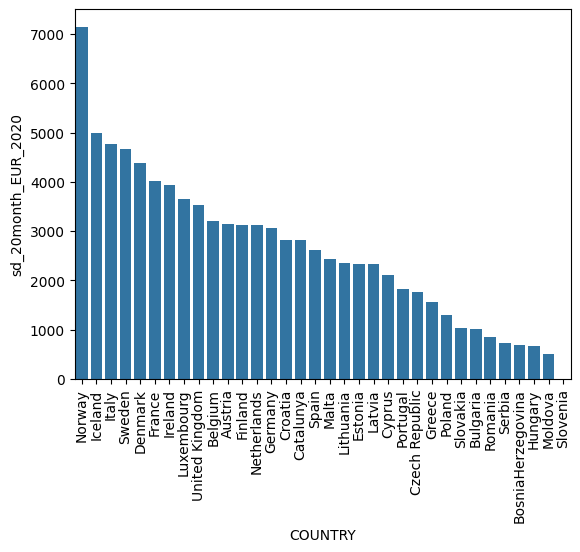

In [69]:
datalc1= data.groupby('COUNTRY')['sd_20month_EUR_2020'].mean().sort_values(ascending=False)

#diagramme du salaire mensuel moyen par pays (en cl d'alcool pur par an)
datalc1 = datalc1.reset_index()
sns.barplot(x='COUNTRY', y='sd_20month_EUR_2020', data=datalc1)
plt.xticks(rotation=90)
plt.show()

In [70]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

def imputer_salaire_pays(df, pays_cible, colonne_salaire='salaire', colonne_pays='pays'):
    # 1. Filtrer pour le pays donné
    df_pays = df[df[colonne_pays] == pays_cible].copy()
    salaires_avant = df[df['COUNTRY'] == pays_cible]['sd_20month_EUR_2020'].dropna()
    
    # Identifier les variables explicatives (toutes sauf le salaire et le pays)
    features = df_pays.drop(columns=[colonne_salaire, colonne_pays])
    
    # 2. Séparer les données connues des données manquantes
    train_data = df_pays[df_pays[colonne_salaire].notna()]
    predict_data = df_pays[df_pays[colonne_salaire].isna()]
    
    if predict_data.empty:
        print(f"Aucune valeur manquante pour le pays : {pays_cible}")
        return df

    # Préparation des X et y pour l'entraînement
    X = features.loc[train_data.index]
    y = train_data[colonne_salaire]
    
    # 3. Évaluation des performances (Validation croisée simple)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = RandomForestRegressor(n_estimators=100, 
    max_depth=6,              # la profondeur de l'arbre
    min_samples_leaf=5,       # Minimum d'individus par feuille
    max_features='sqrt',      # Utilise moins de colonnes par arbre
    random_state=42)
    model.fit(X_train, y_train)
    
    y_pred_test = model.predict(X_test)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred_test, y_test, alpha=0.7, color='blue', label='Données de test')
    plt.title(f'Prédictions vs Réel pour {pays_cible}')
    plt.xlabel('Prédictions')
    plt.ylabel('Valeurs Réelles')
    plt.legend()    
    plt.show()
    
    
    print(f"--- Performances du modèle pour {pays_cible} ---")
    print(f"Score R² : {r2_score(y_test, y_pred_test):.4f}")
    print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}")
    print("--------------------------------------------\n")
    
    

    # 4. Imputation réelle
    # Ré-entraînement sur toute la donnée disponible du pays
    model.fit(X, y)
    X_miss = features.loc[predict_data.index]
    predictions = model.predict(X_miss)

    
    # Insertion des valeurs prédites dans le DataFrame original
    df.loc[predict_data.index, colonne_salaire] = predictions

    salaires_apres = df[df['COUNTRY'] == pays_cible]['sd_20month_EUR_2020']

    # Prédictions sur l'ensemble des données manquantes pour visualisation

    plt.figure(figsize=(10, 6))
    sns.kdeplot(salaires_avant, label='Avant imputation (Réel)', shade=True, color="skyblue", bw_adjust=1)
    sns.kdeplot(salaires_apres, label='Après imputation (Complet)', color="red", linestyle="--")
    
    plt.title(f"Distribution des salaires pour : {pays_cible}")
    plt.xlabel("Salaire mensuel")
    plt.ylabel("Densité")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


# Exemple d'utilisation :
# df_final = imputer_salaire_pays(votre_dataframe, "France")

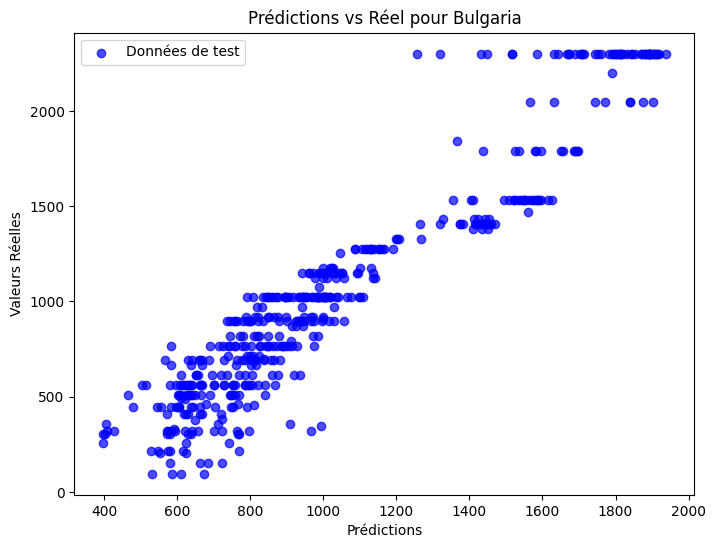

--- Performances du modèle pour Bulgaria ---
Score R² : 0.8179
RMSE : 256.28
--------------------------------------------



C:\Users\7king\AppData\Local\Temp\ipykernel_12600\4167407404.py:69: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(salaires_avant, label='Avant imputation (Réel)', shade=True, color="skyblue", bw_adjust=1)


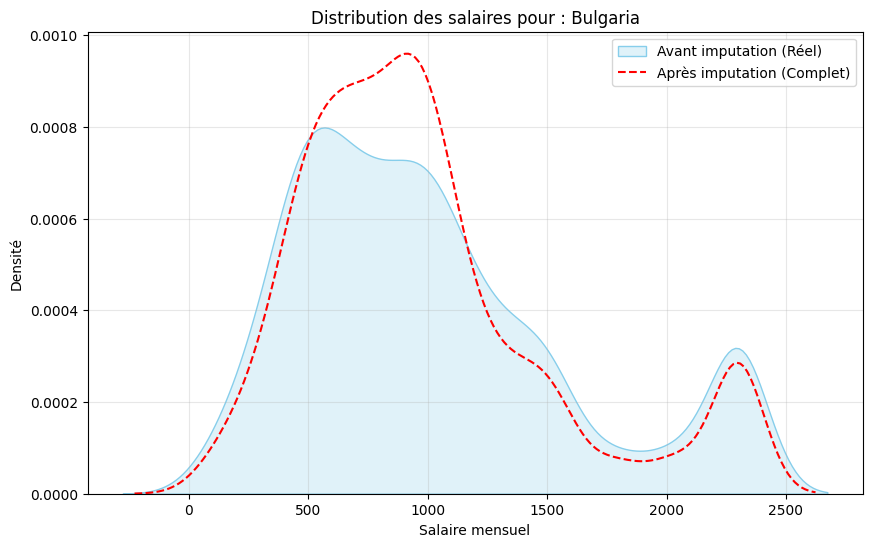

In [71]:
d = imputer_salaire_pays(data, "Bulgaria", colonne_salaire='sd_20month_EUR_2020', colonne_pays='COUNTRY')

In [ ]:
def imputer_frequence_knn(df, pays_cible, col_frequence='frequence_conso', n_voisins=5):
    # 1. Filtrer par pays
    df_pays = df[df['COUNTRY'] == pays_cible].copy()
    
    # Sauvegarde pour la visualisation
    frequence_avant = df_pays[col_frequence].dropna()
    
    # 2. Préparation des données
    # Le KNN est sensible à l'échelle des données. Il faut normaliser les autres variables.
    features = df_pays.drop(columns=['COUNTRY']) # On garde la colonne fréquence (avec ses NaN)
    
    # normalisation
    X = features.copy()
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

    # 3. Application du KNN Imputer
    imputer = KNNImputer(n_neighbors=n_voisins)
    X_imputed = pd.DataFrame(imputer.fit_transform(X_scaled), columns=X.columns, index=X.index)
    
    # 4. Retour à l'échelle originale et extraction de la colonne fréquence
    # On dé-standardise pour récupérer les valeurs originales
    X_final = pd.DataFrame(scaler.inverse_transform(X_imputed), columns=X.columns, index=X.index)
    
    # Comme le KNN renvoie des moyennes, on arrondit pour rester dans les catégories 1-10
    valeurs_imputees = X_final[col_frequence].round()
    
    # Mise à jour du DataFrame original
    df.loc[df_pays.index, col_frequence] = valeurs_imputees
    
    # 5. Visualisation par Courbe de Densité
    frequence_apres = df.loc[df_pays.index, col_frequence]
    
    plt.figure(figsize=(12, 6))
    sns.histplot(frequence_avant, label='Original (Réel)', fill=True, color="teal", alpha=0.5)
    sns.histplot(frequence_apres, label='Après KNN Imputation', color="orange", alpha=0.5)

    plt.title(f"Impact de l'imputation KNN sur la Fréquence (Pays: {pays_cible})")
    plt.xticks(range(1, 11)) # Pour bien voir les catégories de 1 à 10
    plt.xlabel("Catégories de fréquence (1=Quotidien, 10=Jamais)")
    plt.ylabel("Densité")
    plt.legend()
    plt.grid(axis='x', alpha=0.3)
    plt.show()
    
    # Affichage des statistiques pour vérifier si on n'a pas trop de biais
    print(f"Moyenne avant : {frequence_avant.mean():.2f}")
    print(f"Moyenne après  : {frequence_apres.mean():.2f}")
    
    return df

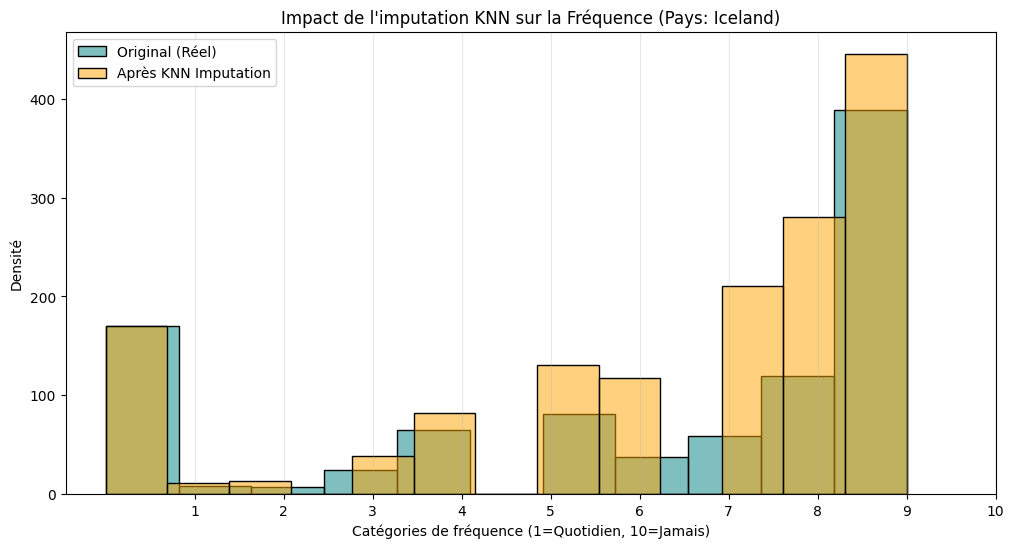

Moyenne avant : 6.10
Moyenne après  : 6.38


,COUNTRY,SD_1,SD_2,SD_4,SD_6,SD_7,SD_8,SD_9,SD_10,sd_20month,...,cbsqf_beer,cbsqf_spir,cbsqf_wine,RSOD_5d,RSOD_2b,RSOD_7b,CH_1,WB_1,WB_2,WB_3
0,United Kingdom,1,61,1,2,0.0,4,3,2,666.666667,...,108.000,0.0,22.05,NaN,NaN,NaN,1,3,2,1
1,United Kingdom,1,37,4,1,NaN,3,2,1,2083.333333,...,2548.260,561.6,2184.00,4.0,3.0,3.0,1,3,4,5
2,Lithuania,1,42,1,2,2.0,4,4,1,1500.000000,...,0.000,0.0,0.00,NaN,0.0,0.0,1,2,2,2
3,Lithuania,1,37,3,1,NaN,4,2,1,1500.000000,...,5720.000,1200.0,18.90,4.0,2.0,2.0,1,3,3,2
4,Lithuania,2,60,4,1,NaN,2,3,2,1500.000000,...,1.250,0.0,43.20,5.0,8.0,8.0,1,3,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56009,Cyprus,1,41,1,2,0.0,1,4,1,3500.000000,...,195.000,24.0,140.40,5.0,4.0,4.0,2,3,2,2
56010,Cyprus,1,29,3,2,0.0,3,4,1,2500.000000,...,150.000,60.0,1029.60,5.0,8.0,8.0,2,3,2,2
56011,Cyprus,2,30,1,2,0.0,3,4,1,2000.000000,...,4.375,4.2,0.00,NaN,NaN,NaN,2,2,2,1
56012,Cyprus,2,32,1,2,1.0,3,2,1,1000.000000,...,148.500,180.0,0.96,5.0,8.0,NaN,1,1,1,2


In [85]:
imputer_frequence_knn(data, "Iceland", col_frequence='RSOD_2b', n_voisins=5)